# ***Layer Class***

In [117]:
import numpy as np
import pickle
import json

class Layer:
    def forward(self, input):
        raise NotImplementedError("Error in forward pass")

    def backward(self, grad_output):
        raise NotImplementedError("error in backward pass")


class Linear(Layer):
    def __init__(self, in_features, out_features):

        self.weights = np.random.randn(out_features, in_features) * np.sqrt(2.0 / in_features)
        self.bias = np.zeros((out_features,))
        self.input = None
        self.grad_weights = None
        self.grad_bias = None

    def forward(self, input):

        self.input = input

        return np.dot(input, self.weights.T) + self.bias

    def backward(self, grad_output):

        self.grad_weights = np.dot(grad_output.T, self.input)
        self.grad_bias = np.sum(grad_output, axis=0)

        return np.dot(grad_output, self.weights)


class Sigmoid(Layer):
    def forward(self, input):

        self.output = 1 / (1 + np.exp(-input))
        return self.output

    def backward(self, grad_output):

        return grad_output * self.output * (1 - self.output)

class ReLU(Layer):
    def forward(self, input):
        self.input = input
        self.output = np.maximum(0, input)
        return self.output

    def backward(self, grad_output):

        grad_input = grad_output.copy()
        grad_input[self.input <= 0] = 0
        return grad_input


class Tanh(Layer):
    def forward(self, input):
        self.output = np.tanh(input)
        return self.output

    def backward(self, grad_output):

        return grad_output * (1 - self.output ** 2)


class BinaryCrossEntropyLoss(Layer):
    def forward(self, predictions, targets):

        self.predictions = np.clip(predictions, 1e-12, 1 - 1e-12)
        self.targets = targets
        loss = - (targets * np.log(self.predictions) +
                  (1 - targets) * np.log(1 - self.predictions))

        return np.mean(loss)

    def backward(self):

        n = self.targets.shape[0]
        grad = -(self.targets / self.predictions) + ((1 - self.targets) / (1 - self.predictions))
        return grad / n




class Sequential(Layer):
    def __init__(self, layers):
        self.layers = layers

    def forward(self, input):
        for layer in self.layers:
            input = layer.forward(input)
        return input

    def backward(self, grad_output):

        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output)
        return grad_output









    def save(self, filename):

        params = {}
        for i, layer in enumerate(self.layers):
            if isinstance(layer, Linear):
                params[f"layer_{i}_weights"] = layer.weights.tolist()
                params[f"layer_{i}_bias"] = layer.bias.tolist()

        with open(filename, 'w') as f:
            json.dump(params, f, indent=4)
        print(f"parameter file saved to {filename}")



    def load(self, filename):

        with open(filename, 'r') as f:
            data = json.load(f)

        for i, layer in enumerate(self.layers):
            if isinstance(layer, Linear):
                layer.weights = np.array(data[f"layer_{i}_weights"])
                layer.bias = np.array(data[f"layer_{i}_bias"])

        print(f"Model parameters loaded from {filename}")








# *XOR Model*

In [122]:
import json
def train_model(model, save_path="XOR_solved"):

    X = np.array([[0, 0],
                  [0, 1],
                  [1, 0],
                  [1, 1]])
    y = np.array([[0],
                  [1],
                  [1],
                  [0]])

    loss_layer = BinaryCrossEntropyLoss()
    learning_rate = 0.1
    epochs = 10000


    loss_history = []

    for epoch in range(epochs):

        predictions = model.forward(X)
        loss = loss_layer.forward(predictions, y)
        loss_history.append(loss)


        grad_loss = loss_layer.backward()
        model.backward(grad_loss)


        for layer in model.layers:
            if isinstance(layer, Linear):
                layer.weights -= learning_rate * layer.grad_weights
                layer.bias -= learning_rate * layer.grad_bias

        if epoch % 1000 == 0:
            print(f"Epoch {epoch}: Loss = {loss}")


    import matplotlib.pyplot as plt
    plt.figure(figsize=(8, 5))
    plt.plot(loss_history)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.show()


    predictions = model.forward(X)
    print("\nFinal predictions after training:")
    print(predictions)

    model.save(save_path)

    return model, loss_history


# ***XOR Model with Sigmoid Activation***

Epoch 0: Loss = 0.7653431615135421
Epoch 1000: Loss = 0.5950148586913305
Epoch 2000: Loss = 0.2071430158162368
Epoch 3000: Loss = 0.08078567408966039
Epoch 4000: Loss = 0.04681051404344364
Epoch 5000: Loss = 0.03235268264350498
Epoch 6000: Loss = 0.024537086383623737
Epoch 7000: Loss = 0.019690279100894208
Epoch 8000: Loss = 0.01640775191209798
Epoch 9000: Loss = 0.014044641347610066


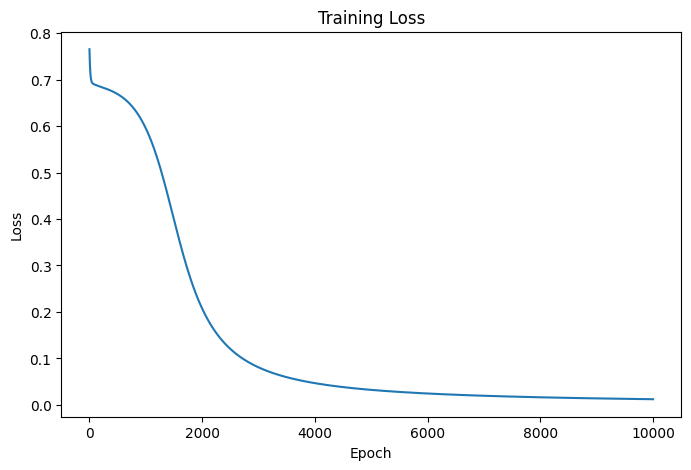


Final predictions after training:
[[0.01437825]
 [0.9889027 ]
 [0.98908576]
 [0.01236903]]
parameter file saved to XOR_Sigmoid_solved.json


In [134]:
model = Sequential([
    Linear(2, 2),
    Sigmoid(),
    Linear(2, 1),
    Sigmoid()
])
trained_model, loss_sigmoid = train_model(model,"XOR_Sigmoid_solved.json")


In [129]:
model_sigmoid_loaded = Sequential([
    Linear(2, 2),
    Sigmoid(),
    Linear(2, 1),
    Sigmoid()
])

model_sigmoid_loaded.load("XOR_Sigmoid_solved.json")

# Test predictions on XOR input
X_test = np.array([[0, 0], [0, 1], [1, 0], [1, 1]])
print("Predictions after loading saved Sigmoid model:")
print(model_sigmoid_loaded.forward(X_test))

Model parameters loaded from XOR_Sigmoid_solved.json
Predictions after loading saved Sigmoid model:
[[0.01117513]
 [0.98512402]
 [0.98512304]
 [0.01359255]]


# ***XOR Model with Tanh Activation***

Epoch 0: Loss = 0.78624778238003
Epoch 1000: Loss = 0.0581634973447558
Epoch 2000: Loss = 0.02117612593527722
Epoch 3000: Loss = 0.01273306002583965
Epoch 4000: Loss = 0.009064629880274616
Epoch 5000: Loss = 0.007024616496955407
Epoch 6000: Loss = 0.005728790696516665
Epoch 7000: Loss = 0.0048339105026716615
Epoch 8000: Loss = 0.004179333947785991
Epoch 9000: Loss = 0.003679982628013833


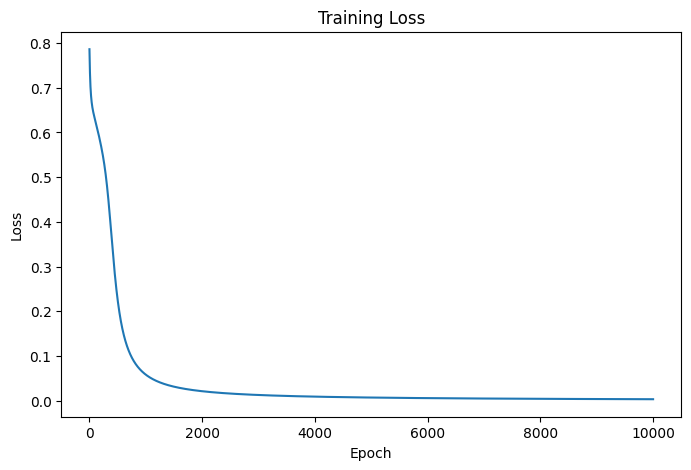


Final predictions after training:
[[0.002418  ]
 [0.99569959]
 [0.99567539]
 [0.00207977]]
parameter file saved to XOR_Tanh_solved.json


In [137]:
model = Sequential([
    Linear(2, 2),
    Tanh(),
    Linear(2, 1),
    Sigmoid()
])
trained_model, loss_tanh = train_model(model,"XOR_Tanh_solved.json")

In [132]:
model_tanh_loaded = Sequential([
    Linear(2, 2),
    Tanh(),
    Linear(2, 1),
    Sigmoid()
])

model_tanh_loaded.load("XOR_Tanh_solved.json")

print("Predictions after loading saved Tanh model:")
print(model_tanh_loaded.forward(X_test))

Model parameters loaded from XOR_Tanh_solved.json
Predictions after loading saved Tanh model:
[[0.00170386]
 [0.49928259]
 [0.99850514]
 [0.50062761]]


# ***Comparision Graph between Sigmoid and Tanh***

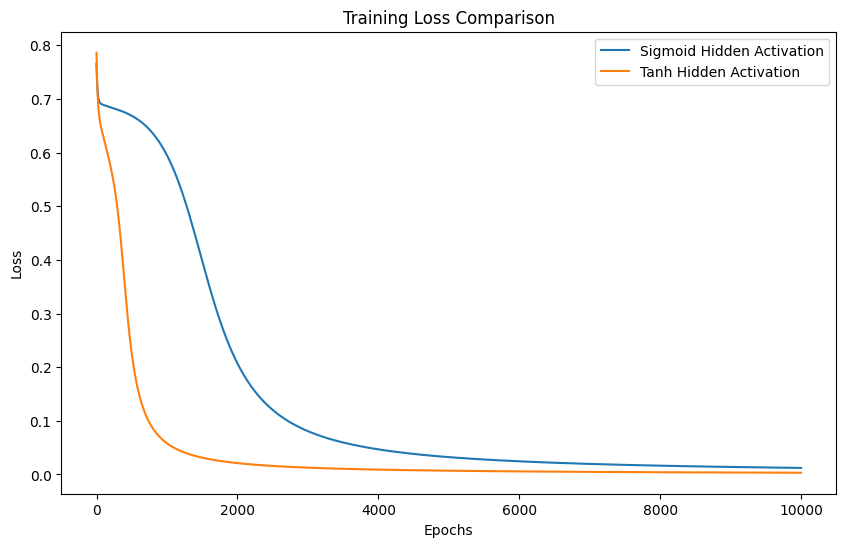

In [138]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(loss_sigmoid, label='Sigmoid Hidden Activation')
plt.plot(loss_tanh, label='Tanh Hidden Activation')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss Comparison')
plt.legend()
plt.show()

The Tanh activation architecture trains better than the Sigmoid activation architecture.

In [111]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# ***Data Pre-Processing***


<p style="text-align: justify;">
In the preprocessing stage, I excluded certain features that do not contribute significantly to predicting trip duration. The id and vendor_id were removed as they serve only as identifiers with no predictive value. Similarly, store_and_fwd_flag was excluded since it relates to data transmission rather than trip characteristics. Additionally, pickup_datetime and dropoff_datetime were dropped after a heatmap analysis (performed in Feature Selection.ipynb) showed no correlation with trip duration. This ensures that the model focuses only on meaningful features for better accuracy and efficiency.
</p>

In [112]:


dataset = np.load("nyc_taxi_data.npy", allow_pickle=True).item()
X_train, y_train, X_test, y_test = (
    dataset["X_train"],
    dataset["y_train"],
    dataset["X_test"],
    dataset["y_test"],
)
#features selected after doing heatmap analysis
features = [
    "pickup_longitude", "pickup_latitude",
    "dropoff_longitude", "dropoff_latitude",
    "passenger_count"
]


df_train = pd.DataFrame(X_train, columns=features)
df_train["trip_duration"] = y_train

#Normalization

scaler = StandardScaler()
df_train_normalized = df_train.copy()
df_train_normalized[features] = scaler.fit_transform(df_train[features])


min_duration = df_train["trip_duration"].min()
max_duration = df_train["trip_duration"].max()
y_norm = ((df_train["trip_duration"] - min_duration) / (max_duration - min_duration)).values.reshape(-1, 1)

X_features = df_train_normalized[features].values


X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_features, y_norm, test_size=0.2, random_state=42
)


df_test = pd.DataFrame(X_test, columns=features)
df_test["trip_duration"] = y_test

df_test_normalized = df_test.copy()
df_test_normalized[features] = scaler.transform(df_test[features])
X_test_features = df_test_normalized[features].values
y_test_norm = ((df_test["trip_duration"] - min_duration) / (max_duration - min_duration)).values.reshape(-1, 1)


# ***Functions to Evaluate Model using RMLSE***

In [113]:
import numpy as np

def RMLSE(predictions, targets):

    log_predictions = np.log1p(predictions)
    log_targets = np.log1p(targets)

    return np.sqrt(np.mean((log_predictions - log_targets) ** 2))

def evaluate_model(model, X_test, y_test):
    predictions = model.forward(X_test)
    rmlse = RMLSE(predictions, y_test)
    return rmlse, predictions


# ***Create Model Function***

In [114]:
def build_model(input_dim, hidden_layers, activation):

    layers = []
    prev_dim = input_dim
    for nodes in hidden_layers:
        layers.append(Linear(prev_dim, nodes))
        if activation == "sigmoid":
            layers.append(Sigmoid())
        elif activation == "tanh":
            layers.append(Tanh())
        elif activation == "relu":
            layers.append(ReLU())
        else:
            raise ValueError("Invalid Activation function")
        prev_dim = nodes

    layers.append(Linear(prev_dim, 1))
    layers.append(Sigmoid())
    return Sequential(layers)




# ***Model Training Function***

In [115]:
def train_model(model, loss_layer, X_train, y_train, X_val, y_val, learning_rate, max_epochs, patience):

    train_losses = []
    val_losses = []
    best_val_loss = float("inf")
    x = 0

    for epoch in range(max_epochs):

        predictions_train = model.forward(X_train)
        loss_train = loss_layer.forward(predictions_train, y_train)
        grad_loss = loss_layer.backward()
        model.backward(grad_loss)

        for layer in model.layers:
            if isinstance(layer, Linear):
                layer.weights -= learning_rate * layer.grad_weights
                layer.bias -= learning_rate * layer.grad_bias
        train_losses.append(loss_train)


        predictions_val = model.forward(X_val)
        loss_val = loss_layer.forward(predictions_val, y_val)
        val_losses.append(loss_val)


        if loss_val < best_val_loss:
            best_val_loss = loss_val
            x = 0
        else:
            x += 1

        if x >= patience:
            print(f"Early stopping at epoch {epoch}")
            break

        if epoch % 20 == 0:
            print(f"Epoch {epoch}: Train Loss = {loss_train:.4f}, Val Loss = {loss_val:.4f}")

    return train_losses, val_losses

# ***Model-1***


<p style="text-align: justify;">The first model consists of a single hidden layer with 4 nodes, utilizing a Sigmoid activation function, followed by a Sigmoid output layer.
</p>


Training Model 1...
Epoch 0: Train Loss = 0.4172, Val Loss = 0.4146
Epoch 20: Train Loss = 0.3746, Val Loss = 0.3724
Epoch 40: Train Loss = 0.3386, Val Loss = 0.3367
Epoch 60: Train Loss = 0.3079, Val Loss = 0.3063
Epoch 80: Train Loss = 0.2816, Val Loss = 0.2801

Model 1 Test RMLSE: 0.2067


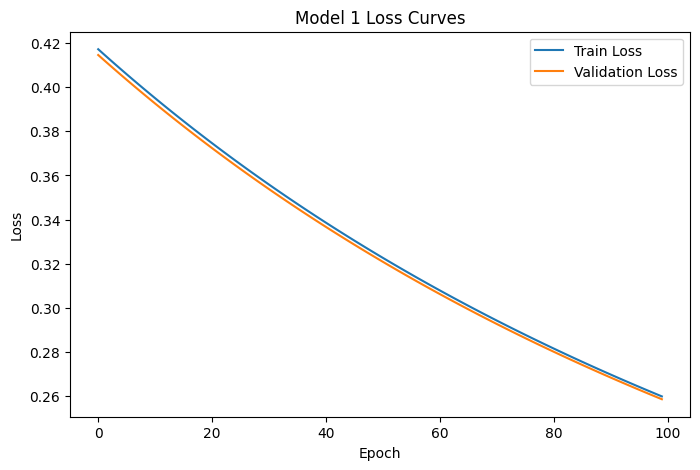

In [116]:
print("\nTraining Model 1...")


model = build_model(
    input_dim=X_train_split.shape[1],
    hidden_layers=[4],
    activation="sigmoid"
)
loss_layer = BinaryCrossEntropyLoss()


train_losses, val_losses = train_model(
    model, loss_layer, X_train_split, y_train_split, X_val, y_val,
    learning_rate=0.01,
    max_epochs=100,
    patience=3
)


rmlse, predictions = evaluate_model(model, X_test_features, y_test_norm)
print(f"\nModel 1 Test RMLSE: {rmlse:.4f}")



plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Model 1 Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


# ***Model-2***


<p style="text-align: justify;">
The second model is structured with two hidden layers of 8 and 4 nodes, employing a ReLU activation function, and a Sigmoid output layer
</p>


Training Model 2...
Epoch 0: Train Loss = 1.1646, Val Loss = 1.1603
Epoch 20: Train Loss = 1.0018, Val Loss = 0.9992
Epoch 40: Train Loss = 0.8830, Val Loss = 0.8812
Epoch 60: Train Loss = 0.7926, Val Loss = 0.7912
Epoch 80: Train Loss = 0.7210, Val Loss = 0.7198

Model 3 Test RMLSE: 0.3894


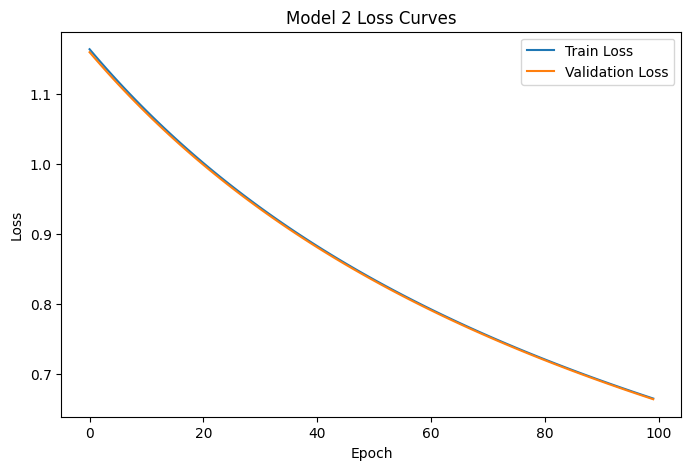

In [107]:
print("\nTraining Model 2...")


model = build_model(
    input_dim=X_train_split.shape[1],
    hidden_layers=[8, 4],
    activation="relu"
)
loss_layer = BinaryCrossEntropyLoss()


train_losses, val_losses = train_model(
    model, loss_layer, X_train_split, y_train_split, X_val, y_val,
    learning_rate=0.005,
    max_epochs=100,
    patience=3
)

rmlse, predictions = evaluate_model(model, X_test_features, y_test_norm)
print(f"\nModel 3 Test RMLSE: {rmlse:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Model 2 Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


# ***Model-3***



<p style="text-align: justify;">The third model incorporates three hidden layers with 20, 20, and 15 nodes, using a Sigmoid activation function, and concluding with a Sigmoid output layer.</p>


Training Model 3...


<ipython-input-6-eaf638dba58e>:40: RuntimeWarning: overflow encountered in exp
  self.output = 1 / (1 + np.exp(-input))


Epoch 0: Train Loss = 0.9493, Val Loss = 0.9471
Epoch 20: Train Loss = 0.9069, Val Loss = 0.9047
Epoch 40: Train Loss = 0.8668, Val Loss = 0.8647
Epoch 60: Train Loss = 0.8289, Val Loss = 0.8269
Epoch 80: Train Loss = 0.7931, Val Loss = 0.7913

Model 3 Test RMLSE: 0.4263


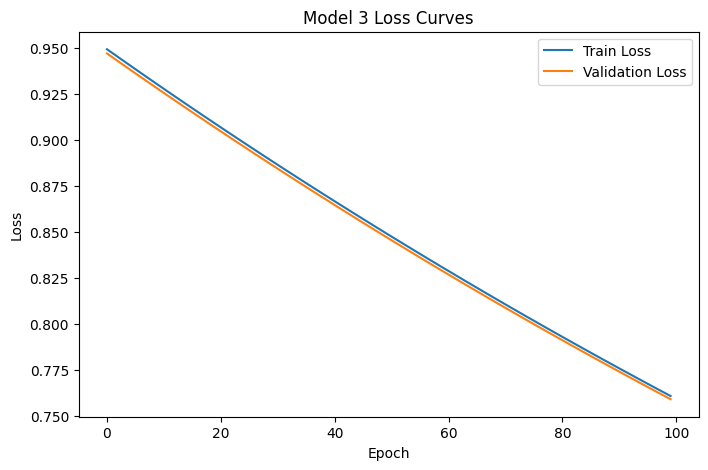

In [18]:
print("\nTraining Model 3...")


model = build_model(
    input_dim=X_train_split.shape[1],
    hidden_layers=[20, 20, 15],
    activation="sigmoid"
)
loss_layer = BinaryCrossEntropyLoss()


train_losses, val_losses = train_model(
    model, loss_layer, X_train_split, y_train_split, X_val, y_val,
    learning_rate=0.001,
    max_epochs=100,
    patience=3
)


rmlse, predictions = evaluate_model(model, X_test_features, y_test_norm)
print(f"\nModel 3 Test RMLSE: {rmlse:.4f}")



plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Model 3 Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()


# ***Model-4***



<p style="text-align: justify;">The fourth model incorporates three hidden layers with 8, 8, and 4 nodes, using a tanh activation function, and concluding with a Sigmoid output layer.</p>


Training Model 4...
Epoch 0: Train Loss = 0.6946, Val Loss = 0.6928
Epoch 20: Train Loss = 0.6388, Val Loss = 0.6373
Epoch 40: Train Loss = 0.5897, Val Loss = 0.5885
Epoch 60: Train Loss = 0.5462, Val Loss = 0.5452
Epoch 80: Train Loss = 0.5073, Val Loss = 0.5065

Model 3 Test RMLSE: 0.3188


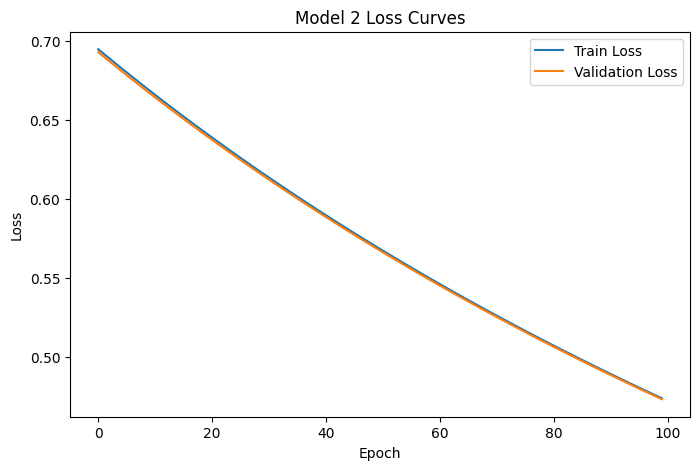

In [109]:
print("\nTraining Model 4...")

model = build_model(
    input_dim=X_train_split.shape[1],
    hidden_layers=[8,8, 4],
    activation="tanh"
)
loss_layer = BinaryCrossEntropyLoss()


train_losses, val_losses = train_model(
    model, loss_layer, X_train_split, y_train_split, X_val, y_val,
    learning_rate=0.005,
    max_epochs=100,
    patience=3
)

rmlse, predictions = evaluate_model(model, X_test_features, y_test_norm)
print(f"\nModel 4 Test RMLSE: {rmlse:.4f}")

plt.figure(figsize=(8, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Model 2 Loss Curves")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()
